In [97]:
%matplotlib inline


Transfer Learning for Computer Vision
==============================================
Script is adjusted from the original tutorial at `https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html`

In this notebook, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization for
    the task of interest.


In [98]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [99]:
# Define path to data
data_dir = 'data/cat_data'

In [100]:
# Clean corrupted files
# Source: https://opensource.com/article/17/2/python-tricks-artists
import os
from os import listdir
from PIL import Image

directories = ['train','val']
subdirectories = ['black_and_white_cat','white_and_ginger_cat']
   
for directory in directories:
    for subdir in subdirectories:
        for filename in listdir(os.path.join(data_dir,directory,subdir)):
            if filename.endswith('.jpg'):
                try:
                    img = Image.open('./'+filename) # open the image file
                    img.verify() # verify that it is, in fact an image
                except (IOError, SyntaxError) as e:
                    print('Bad file:', directory, subdir, filename) # print out the names of corrupt files
#                     os.remove(os.path.join(data_dir,directory,subdir,filename))

Bad file: train black_and_white_cat 147.Sue-1-1-of-1-800x800.jpg
Bad file: train black_and_white_cat 162.s-l300.jpg
Bad file: train black_and_white_cat 87.Screen-Shot-2019-09-22-at-9.17.45-AM.jpg
Bad file: train black_and_white_cat 109.cat-urn-black-n-white-2.jpg
Bad file: train black_and_white_cat 121.xblack-and-white-sphynx-cat.jpg
Bad file: train black_and_white_cat 115.sweet-black-and-white-cat.jpg
Bad file: train black_and_white_cat 96.cute-black-white-cat-big-eyes-portrait-pet-realistic-drawing-kitten-watercolor-background-cute-black-white-122021709.jpg
Bad file: train black_and_white_cat 134.fotolia_5556849_XS.jpg
Bad file: train black_and_white_cat 168.breed-Cymric.jpg
Bad file: train black_and_white_cat 176.18716-Black-and-white-cat-white-background.jpg
Bad file: train black_and_white_cat 157.2-black-and-white-cats-twins-568a404292841.jpg
Bad file: train black_and_white_cat 72.beautiful-black-and-white-cat-52fcde2ecc512.jpg
Bad file: train black_and_white_cat 185.alCX1w.jpg
Ba

In [101]:
# Overwrite ImageFolder to add corrupted file handling
# import torchvision.datasets as dset
# class ImageFolderEX(dset.ImageFolder):
#     def __getitem__(self, index):
#         path, label = self.imgs[index]
#         try:
#             img = self.loader(os.path.join(self.root, path))
#         except:
#             pass #your handling code
#         return [img, label]

In [102]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



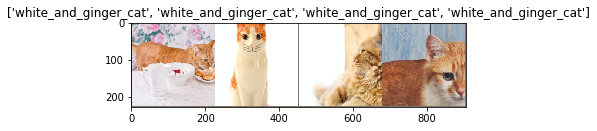

In [103]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [104]:
class_names

['black_and_white_cat', 'white_and_ginger_cat']

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [105]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [106]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [107]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [108]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4447 Acc: 0.7737
val Loss: 0.0884 Acc: 0.9746

Epoch 1/24
----------
train Loss: 0.6517 Acc: 0.8102
val Loss: 0.0732 Acc: 0.9746

Epoch 2/24
----------
train Loss: 0.4954 Acc: 0.8540
val Loss: 0.2671 Acc: 0.9407

Epoch 3/24
----------
train Loss: 0.4281 Acc: 0.8613
val Loss: 0.2793 Acc: 0.9322

Epoch 4/24
----------
train Loss: 0.6767 Acc: 0.7409
val Loss: 0.1559 Acc: 0.9576

Epoch 5/24
----------
train Loss: 0.5818 Acc: 0.7847
val Loss: 0.3329 Acc: 0.9237

Epoch 6/24
----------
train Loss: 0.3127 Acc: 0.8942
val Loss: 0.1242 Acc: 0.9746

Epoch 7/24
----------
train Loss: 0.2148 Acc: 0.9234
val Loss: 0.1766 Acc: 0.9576

Epoch 8/24
----------
train Loss: 0.3249 Acc: 0.8796
val Loss: 0.1306 Acc: 0.9661

Epoch 9/24
----------
train Loss: 0.2155 Acc: 0.9270
val Loss: 0.1403 Acc: 0.9661

Epoch 10/24
----------
train Loss: 0.3137 Acc: 0.8759
val Loss: 0.1277 Acc: 0.9661

Epoch 11/24
----------
train Loss: 0.2218 Acc: 0.9270
val Loss: 0.1230 Acc: 0.9661

Ep

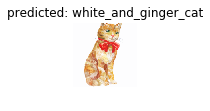

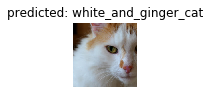

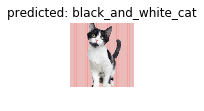

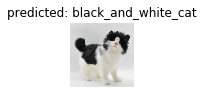

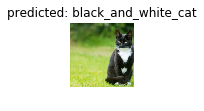

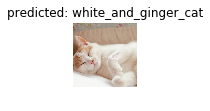

In [109]:
visualize_model(model_ft)

In [110]:
# Save model KK
torch.save(model_ft.state_dict(), 'model.pt')